<a href="https://colab.research.google.com/github/AregSP/hedge-fund-clustering/blob/main/hedge_fund_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The dataset used in this notebook was accessed [here](https://www.kaggle.com/datasets/ironbatshashank/top-100-global-hedge-funds-2020).

In [2]:
import pandas as pd

hedge_funds = pd.read_csv('hedge_funds_list.csv', names = ['name', 'city', 'country', 'aum', 'aum_change', 'strategy']).drop(0)
hedge_funds

,name,city,country,aum,aum_change,strategy
1,AQR Capital Management,Greenwich,United States,"248,897",-0.1,"Multi Strategy, Managed Futures, Event Driven"
2,Bridgewater Associates,Westport,United States,"235,612",0.0,"Long/Short, Global Macro"
3,Citadel Investment Group,Chicago,United States,"234,679",0.2,"Convertibles, Multi Strategy"
4,Millennium Capital Partners,New York,United States,"218,000",NaN,Multi Strategy
5,Renaissance Technologies,East Setauket,United States,"165,968",0.3,"Crypto, Multi Strategy"
...,...,...,...,...,...,...
96,Bayview Asset Management,Coral Gables,United States,"14,700",0.1,Credit
97,Man Group,London,United Kingdom,"14,657",1.0,"Global Macro, Convertibles, Crypto"
98,Aviva Investors,London,United Kingdom,"14,553",0.9,"Convertibles, Multi Strategy, Global Equity"
99,LaSalle Investment Management,Chicago,United States,"14,321",0.0,Real Estate


The dataset consists entirely of strings, and also there's some missing values.

In [3]:
print(hedge_funds.dtypes)
print(hedge_funds.isna().sum())
hedge_funds.describe()

name          object
city          object
country       object
aum           object
aum_change    object
strategy      object
dtype: object
name          0
city          0
country       0
aum           0
aum_change    6
strategy      0
dtype: int64


,name,city,country,aum,aum_change,strategy
count,100,100,100,100,94,100
unique,100,28,9,99,15,85
top,AQR Capital Management,New York,United States,"30,214",0.0,Credit
freq,1,40,76,2,22,4


The majority of hedge funds are located in a couple of US cities and London

In [4]:
hedge_funds['city'].value_counts()

,count
city,
New York,40
London,15
Boston,6
Los Angeles,4
Greenwich,3
Stamford,3
Minneapolis,3
Hong Kong,3
Chicago,3


In [5]:
hedge_funds['strategy'].value_counts()

,count
strategy,
Credit,4
Multi Strategy,3
Fund of Funds,3
0,3
Global Macro,3
...,...
"Crypto, Multi Strategy, Global Macro",1
"Multi Strategy, Commodities, Fixed Income",1
Crypto,1


In [6]:
hedge_funds['country'].value_counts()

,count
country,
United States,76
United Kingdom,15
Hong Kong,3
France,1
Switzerland,1
Brazil,1
Australia,1
Denmark,1
Sweden,1


Theres a slight correlation between AUM and AUM change rate, implying that huge firms are getting more huge

In [7]:
hedge_funds_copy = hedge_funds.copy()

# convert the numeric features to numeric data format
hedge_funds_copy['aum'] = hedge_funds_copy['aum'].str.replace(',', '').astype(int)
hedge_funds_copy['aum_change'] = pd.to_numeric(hedge_funds_copy['aum_change'])


num_df = hedge_funds_copy[['aum', 'aum_change']]
num_df.corr()

,aum,aum_change
aum,1.000000,0.052872
aum_change,0.052872,1.000000


Numerical columns are skewed and would benefit from some sort of transformation, especially AUM

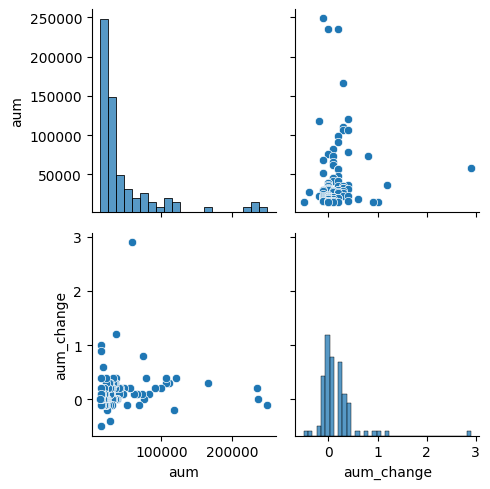

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(num_df)
plt.tight_layout()
plt.show()

Determine the best transformation for numerical columns by plotting square root, cube root, log and yeo johnson transformations

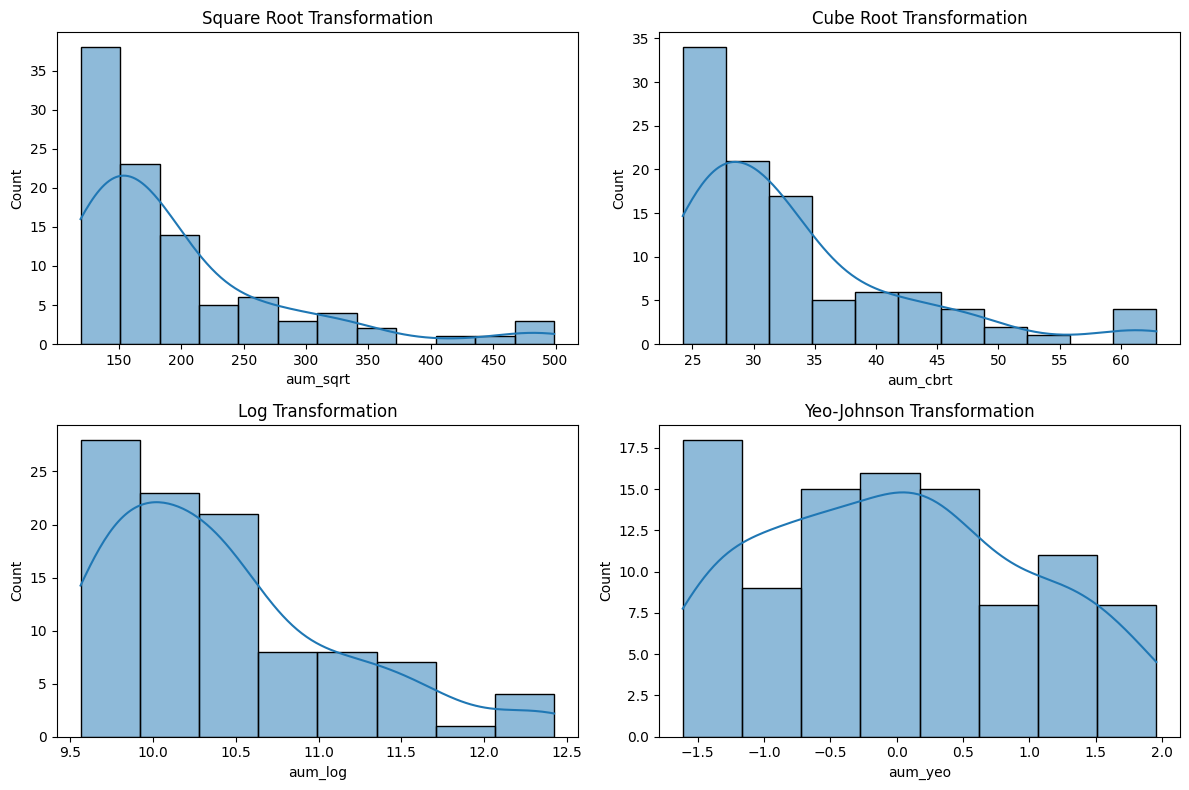

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


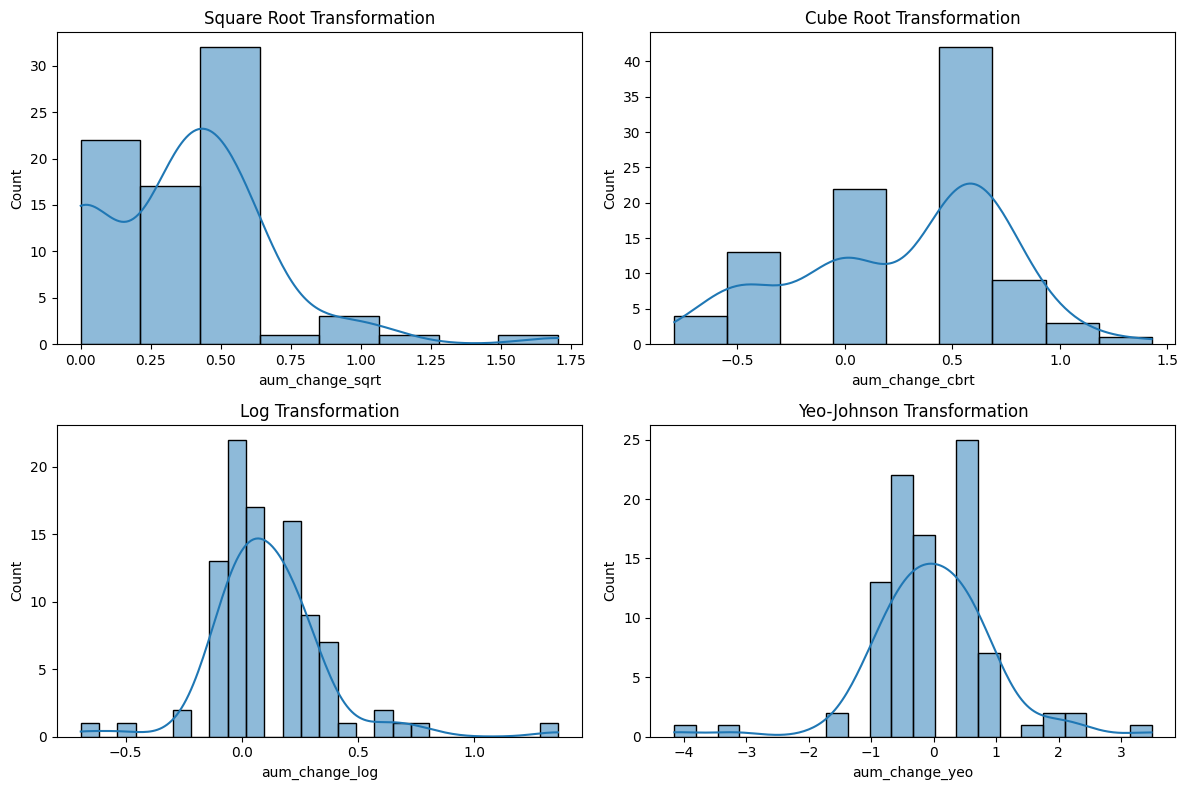

In [10]:
import numpy as np
from sklearn.preprocessing import PowerTransformer

# We'll create a function to plot different transformations

def plot_transformations(df, column):
  fig, axs = plt.subplots(2, 2, figsize=(12, 8))
  axs = axs.flatten()

  # Square root transformation
  df[column + '_sqrt'] = np.sqrt(df[column])
  sns.histplot(df[column + '_sqrt'], ax=axs[0], kde=True)
  axs[0].set_title('Square Root Transformation')

  # Cube root transformation
  df[column + '_cbrt'] = np.cbrt(df[column])
  sns.histplot(df[column + '_cbrt'], ax=axs[1], kde=True)
  axs[1].set_title('Cube Root Transformation')

  # Log transformation (add 1 to avoid log(0))
  df[column + '_log'] = np.log(df[column] + 1)
  sns.histplot(df[column + '_log'], ax=axs[2], kde=True)
  axs[2].set_title('Log Transformation')

  # Yeo-Johnson transformation
  pt = PowerTransformer(method='yeo-johnson')
  df[column + '_yeo'] = pt.fit_transform(df[[column]])
  sns.histplot(df[column + '_yeo'], ax=axs[3], kde=True)
  axs[3].set_title('Yeo-Johnson Transformation')

  plt.tight_layout()
  plt.show()

# Apply the function to numerical columns
plot_transformations(hedge_funds_copy, 'aum')
plot_transformations(hedge_funds_copy, 'aum_change')

# best transformations:
# aum - yeo johnson
# aum change - log

# Data Preprocessing

In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

num_columns = ['yeo_aum', 'log_aum_change']
cat_columns = ['city', 'country']

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
      pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X_copy = X.copy()

      # convert the numerical features to numeric dtypes
      X_copy['aum'] = X_copy['aum'].str.replace(',', '').astype(int)
      X_copy['aum_change'] = pd.to_numeric(X_copy['aum_change'])

      # apply transformations on numeric features
      X_copy['yeo_aum'] = PowerTransformer(method='yeo-johnson').fit_transform(X_copy[['aum']])
      X_copy['log_aum_change'] = np.log(X_copy['aum_change'] + 1)

      # merge rare cities and countries into 1 category
      X_copy['city'] = X_copy['city'].apply(lambda x: 'Other' if x not in ['New York', 'London', 'Boston', 'Los Angeles'] else x)
      X_copy['country'] = X_copy['country'].apply(lambda x: 'Other' if x not in ['United States', 'United Kingdom'] else x)

      # the 'strategy' column contains the multiple strategies applied by the hedge fund seperated by commas. based on it we can create a binary / one hot encoded feature for each individual strategy, which results dozens of new features.

      # this dictionary is meant to eliminate the duplicates of the same strategy which may appear because of whitespaces when splitting the original column

      strategy_mapping = {
                  'Multi Strategy': 'Multi Strategy',
                  'Managed Futures': 'Managed Futures',
                  'Event Driven': 'Event Driven',
                  'Long/Short': 'Long/Short',
                  'Global Macro': 'Global Macro',
                  'Convertibles': 'Convertibles',
                  'Crypto': 'Crypto',
                  'Equity': 'Equity',
                  'Global Equity': 'Global Equity',
                  'Private Equity': 'Private Equity',
                  'Special Situations': 'Special Situations',
                  'Fund of Funds': 'Fund of Funds',
                  'Absolute Returns': 'Absolute Returns',
                  'Credit': 'Credit',
                  'Fixed Income': 'Fixed Income',
                  'Consumer Products': 'Consumer Products',
                  'Commodities': 'Commodities',
                  'Real Estate': 'Real Estate',
                  'Distressed Assets': 'Distressed Assets',
                  'Emerging Markets': 'Emerging Markets',
                  'Energy': 'Energy',
                  'Arbitrage': 'Arbitrage',
                  'Value': 'Value',
                  'Derivatives': 'Derivatives',
                  'FX': 'FX',
                  'Asian Equity': 'Asian Equity',
                  'Activist': 'Activist',
                  'Insurance': 'Insurance',
                  'CDO': 'CDO',
                  'UCITS': 'UCITS',
                  'European Equity': 'European Equity'
              }


      # Apply the mapping to standardize strategy names (remove whitespaces,lowercase variants, etc)
      X_copy['strategy'] = X_copy['strategy'].apply(lambda x: ','.join([strategy_mapping.get(item.strip(), item.strip()) for item in x.split(',')]))

      # Split the strategy column by commas
      X_copy_split = X_copy['strategy'].str.split(',', expand=True)

      # Stack the split columns and get unique values
      unique_values = pd.Series(X_copy_split.values.ravel()).dropna().unique()

      # Create binary columns for each unique value (manual one hot encoding)
      for value in unique_values:
          X_copy[f'strategy_{value}'] = X_copy['strategy'].apply(lambda x: 1 if str(value) in x.split(',') else 0)

      X_copy.drop(['name', 'strategy', 'aum', 'aum_change'], axis=1, inplace=True) # those features will not be used further

      return X_copy


# the transformer for filling missing values, normalizing numerical features and one hot encoding categorical columns
fill_scale_encode = ColumnTransformer([
    ('num', make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), num_columns),
    ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first')), cat_columns)
], remainder='passthrough', verbose_feature_names_out=False)


pipeline = make_pipeline(CustomTransformer(), fill_scale_encode)

X = pipeline.fit_transform(hedge_funds)
X_df = pd.DataFrame(X, columns=pipeline.named_steps['columntransformer'].get_feature_names_out())
X_df

,yeo_aum,log_aum_change,city_London,city_Los Angeles,city_New York,city_Other,country_United Kingdom,country_United States,strategy_Multi Strategy,strategy_Managed Futures,...,strategy_Arbitrage,strategy_Value,strategy_Derivatives,strategy_FX,strategy_Asian Equity,strategy_Activist,strategy_Insurance,strategy_CDO,strategy_UCITS,strategy_European Equity
0,1.956787,-0.910023,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.935064,-0.471896,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.933460,0.286262,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.902831,-0.075563,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.774735,0.619108,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.514134,-0.075563,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,-1.522405,2.410458,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,-1.542581,2.197162,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,-1.588487,-0.471896,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Dimensionality Reduction and Clustering: determining the best combination of the number of clusters, t-sne's perplexity hyperparameter and the silhouette score.

In [12]:
from sklearn.manifold import TSNE # a great choice for dimensionality reduction considering the complexity of the data, the desire for 2D visualization, and the small size of the dataset, which makes this algorithm computationally accessible
from sklearn.cluster import KMeans # a standard choice for clustering
from sklearn.metrics import silhouette_score # the baseline evaluation metric

scores = []
cluster_values = []
perplexity_values = []

perplexity = np.arange(0.91, 1.05, 0.01) # grid search for t-sne

# for each number of clusters, this loop performs dimensionality reduction on the processed dataset using t-sne with a different perplexity each time, performs clustering on the reduced dataset using k-means, and stores the resulting silhouette score. at the end the best combination of the number of clusters, perplexity and silhouette score is printed.
run = False
if run:
  for i in range(8, 31): # the number of clusters considered. this is the range that should provide meaningful results
    for p in perplexity:
      tsne = TSNE(n_components=2, random_state=42, perplexity=p)
      X_tsne = tsne.fit_transform(X)
      kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
      kmeans.fit(X_tsne)
      score = silhouette_score(X_tsne, kmeans.labels_)
      scores.append(score)
      cluster_values.append(i)
      perplexity_values.append(p)

  best_score_index = np.argmax(scores)  # Get the index of the best score
  best_score = scores[best_score_index]
  best_k = cluster_values[best_score_index]  # Get the corresponding cluster value
  best_perplexity = perplexity_values[best_score_index]  # Get the corresponding perplexity value

  print(f"The best number of clusters is {best_k} with a silhouette score of {best_score} and perplexity of {best_perplexity}")

# The best number of clusters is 23 with a silhouette score of
# ~0.857 and perplexity of 1.04

# Visualize the Perplexity, Clusters and Silhouette Scores combinations

In [13]:
from mpl_toolkits.mplot3d import Axes3D

plot = False
if plot:
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(perplexity_values, cluster_values, scores, c=scores, cmap='viridis')

  ax.set_xlabel('Perplexity')
  ax.set_ylabel('Number of Clusters')
  ax.set_zlabel('Silhouette Score')

  ax.set_title('3D Plot of Perplexity, Clusters, and Silhouette Scores')

  plt.show()

# Visualize the clusters

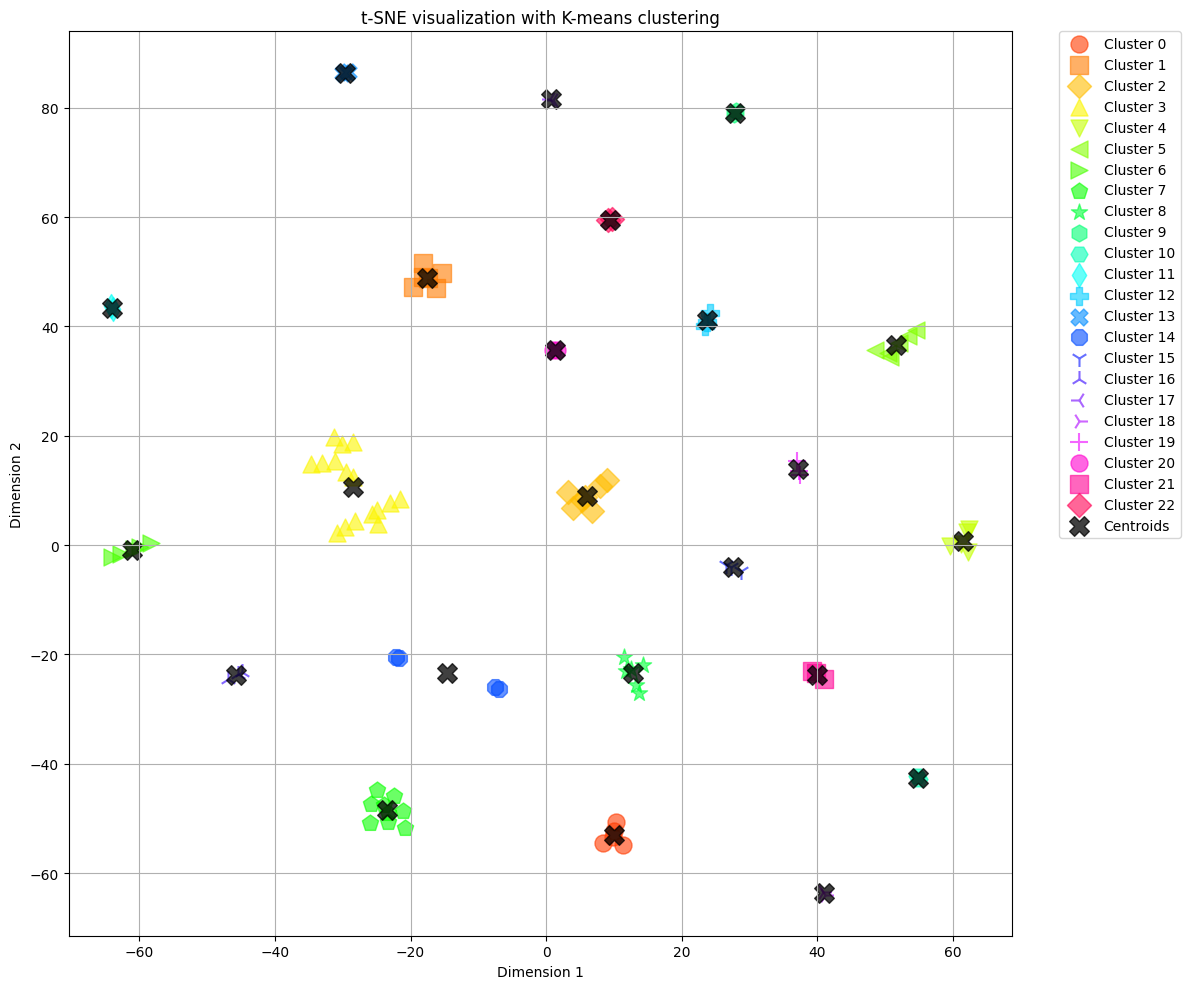

In [14]:
# Perform final dimensionality reduction and clustering with derived hyperparameters
X_tsne = TSNE(n_components=2, random_state=42, perplexity=1.04).fit_transform(X)

kmeans = KMeans(n_clusters=23, random_state=42, n_init=10)
kmeans.fit(X_tsne)

# Generate a color palette with distinct colors
palette = sns.color_palette("hsv", 23)

# Plotting
plt.figure(figsize=(12, 10))

# Assign a different marker for each cluster
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'd', 'P', 'X', '8', '1', '2', '3', '4', '+']

for i in range(23):
    cluster_points = X_tsne[kmeans.labels_ == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[palette[i]], label=f'Cluster {i}', marker=markers[i % len(markers)], s=150, alpha=0.6)

# Plot cluster centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.75, marker='X', label='Centroids')

# Adding titles and labels
plt.title('t-SNE visualization with K-means clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)

# Adding a legend
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Show plot
plt.tight_layout()
plt.show()

# the clusters are well defined and contain reasonable numbers of instances.

# Intrepret the results

Create a DataFrame with clusters as instances.

In [15]:
cluster_info = []

for i in range(23):
  cluster_data = X_df[kmeans.labels_ == i]
  avg_aum = cluster_data['yeo_aum'].mean()
  avg_aum_change = cluster_data['log_aum_change'].mean()

  # number of instances in a cluster
  num_instances = len(cluster_data)

  # Calculate the most common strategy within each cluster
  strategy_columns = [col for col in cluster_data.columns if col.startswith('strategy')]
  if strategy_columns:
    most_common_strategy = cluster_data[strategy_columns].sum().idxmax().split('_')[-1]
  else:
    most_common_strategy = 'N/A'

  # Determine the most common country within each cluster
  country_columns = [col for col in cluster_data.columns if col.startswith('country')]
  if country_columns:
    most_common_country = cluster_data[country_columns].sum().idxmax().split('_')[-1]
  else:
    most_common_country = 'N/A'

  cluster_info.append({
      'num_instances': num_instances,
      'avg_yeo_aum': avg_aum,
      'avg_log_aum_change': avg_aum_change,
      'most_common_country': most_common_country,
      'most_common_strategy': most_common_strategy,
  })

cluster_df = pd.DataFrame(cluster_info)
cluster_df.index.name = 'Cluster'

cluster_df


,num_instances,avg_yeo_aum,avg_log_aum_change,most_common_country,most_common_strategy
Cluster,,,,,
0,5,0.442887,-0.234096,United States,Global Equity
1,6,-0.495328,-0.971971,United Kingdom,Long/Short
2,7,-0.439583,-0.782364,United States,Credit
3,16,0.293217,0.839496,United States,Global Macro
4,5,1.089564,-0.349679,United States,Global Macro
5,6,-1.087653,-0.478862,United States,Multi Strategy
6,5,-1.178992,-0.313363,United States,Credit
7,9,0.981360,0.413330,United States,Global Macro
8,6,0.273818,0.499933,United States,Commodities


# Visualizations

Average AUM and AUM_change across clusters

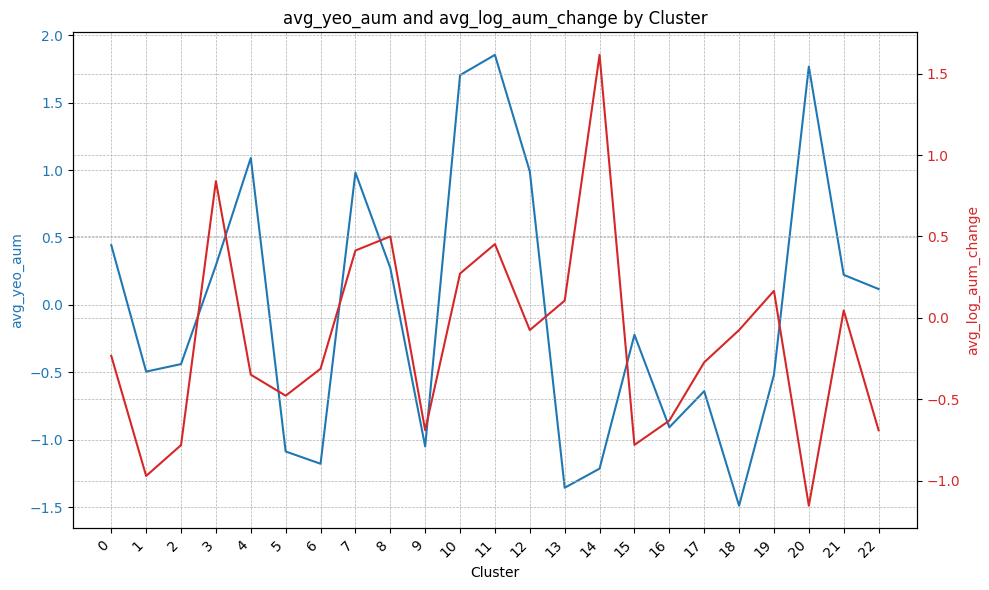

In [16]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot avg_yeo_aum on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Cluster')
ax1.set_ylabel('avg_yeo_aum', color=color)
ax1.plot(cluster_df.index, cluster_df['avg_yeo_aum'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Ensure all x-axis labels are shown
ax1.set_xticks(cluster_df.index)
ax1.set_xticklabels(cluster_df.index, rotation=45, ha='right')

# Add grid to the primary y-axis
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

# Create a second y-axis for avg_log_aum_change
ax2 = ax1.twinx()  # Create a twin axis sharing the same x-axis

color = 'tab:red'
ax2.set_ylabel('avg_log_aum_change', color=color)
ax2.plot(cluster_df.index, cluster_df['avg_log_aum_change'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add grid to the secondary y-axis
ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.title('avg_yeo_aum and avg_log_aum_change by Cluster')
fig.tight_layout()
plt.show()


AUM vs AUM change

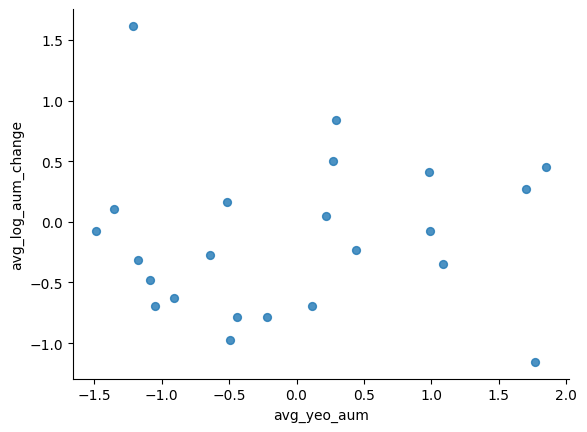

In [17]:
cluster_df.plot(kind='scatter', x='avg_yeo_aum', y='avg_log_aum_change', s=32, alpha=.8)
plt.gca().spines[['top', 'right']].set_visible(False)

Most Common Country

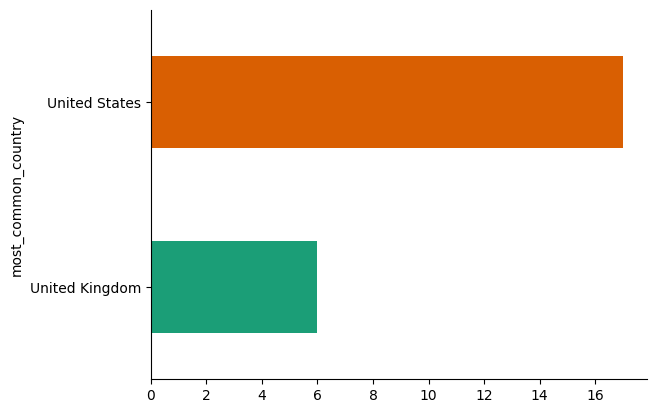

In [18]:
cluster_df.groupby('most_common_country').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Strategy Distributions

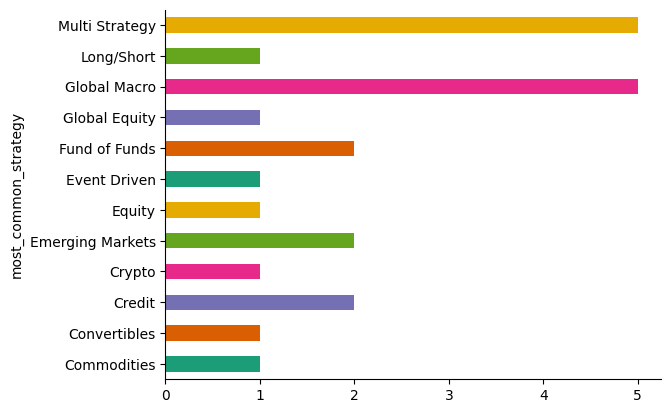

In [19]:
cluster_df.groupby('most_common_strategy').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

We can gain valuable insights from these plots. In particular, Cluster 14 with the highest AUM growth consists of 4 comparably little hedge funds located in London, UK. 2 hedge funds out of them share the Convertibles strategy.

In [20]:
cluster_14 = hedge_funds[kmeans.labels_ == 14]
cluster_14

,name,city,country,aum,aum_change,strategy
65,Alcentra,London,United Kingdom,"22,356",0.4,Distressed Assets
88,Algebris Investments,London,United Kingdom,"15,864",0.4,"Credit, UCITS, Emerging Markets"
97,Man Group,London,United Kingdom,"14,657",1.0,"Global Macro, Convertibles, Crypto"
98,Aviva Investors,London,United Kingdom,"14,553",0.9,"Convertibles, Multi Strategy, Global Equity"


Then there's Cluster 20, which consists of 2 huge American hedge funds which experience decay. Both apply Multi Strategy.

In [21]:
cluster_20 = hedge_funds[kmeans.labels_ == 20]
cluster_20

,name,city,country,aum,aum_change,strategy
1,AQR Capital Management,Greenwich,United States,"248,897",-0.1,"Multi Strategy, Managed Futures, Event Driven"
7,Balyasny Asset Management,Chicago,United States,"118,425",-0.2,"Multi Strategy, Global Equity, Multi Strategy"


Cluster 11 consists of 2 huge American hedge funds which are doing pretty well. Both apply Multi Strategy.

In [22]:
cluster_11 = hedge_funds[kmeans.labels_ == 11]
cluster_11

,name,city,country,aum,aum_change,strategy
3,Citadel Investment Group,Chicago,United States,"234,679",0.2,"Convertibles, Multi Strategy"
5,Renaissance Technologies,East Setauket,United States,"165,968",0.3,"Crypto, Multi Strategy"


Cluster 3 is the biggest, followed by Cluster 7. This can be explained by the fact that both are average in terms of metrics and there's nothing that makes them stand out. Global Macro is the most popular strategy in both clusters.

In [23]:
cluster_3 = hedge_funds[kmeans.labels_ == 3]
cluster_3

,name,city,country,aum,aum_change,strategy
6,Alphadyne Asset Management,New York,United States,"120,723",0.4,"Equity, Managed Futures, Global Macro"
11,Ares Management,Los Angeles,United States,"99,062",0.2,"Managed Futures, Fixed Income, Consumer Products"
21,Brevan Howard Asset Management,London,United Kingdom,"58,630",2.9,"Global Macro, Commodities"
22,Angelo Gordon & Co.,New York,United States,"56,276",0.2,"Real Estate, Fixed Income, Managed Futures"
32,Oaktree Capital Management,Los Angeles,United States,"38,350",0.0,"Fixed Income, Real Estate, Distressed Assets"
35,MKP Capital Management,New York,United States,"35,974",1.2,"Multi Strategy, Fixed Income"
37,Moore Capital Management,New York,United States,"35,454",0.0,"Global Macro, Emerging Markets"
40,BlackRock Alternative Advisors,New York,United States,"33,250",0.3,"Global Macro, Convertibles, Managed Futures"
41,Apollo Capital,New York,United States,"32,680",0.3,"Managed Futures, Credit"
45,Select Equity,New York,United States,"31,643",0.4,"Equity, Long/Short"


Little can be said about the remaining clusters. It is reasonable to make an assumption that they simply were formed by the instances with similar performance and strategies, again nothing special.

# We can also use the clusters to gain insights about the strategies. For example, the plots below illustrate that all the clusters where Equity and Long/Short are the most popular strategies are below the 25th percentile in terms of AUM growth, while the most prosperous clusters (above 75th percentile) apply Convertibles and Commodities.

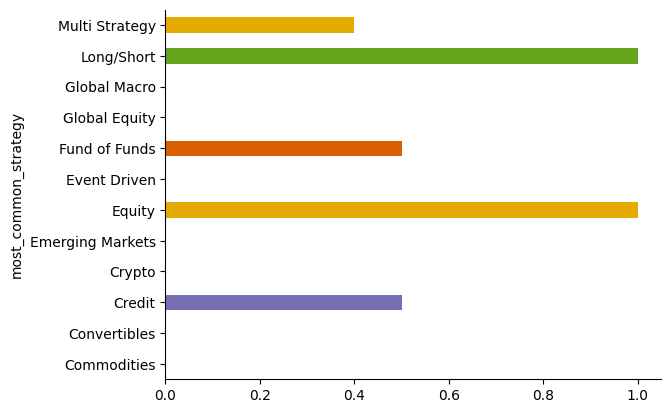

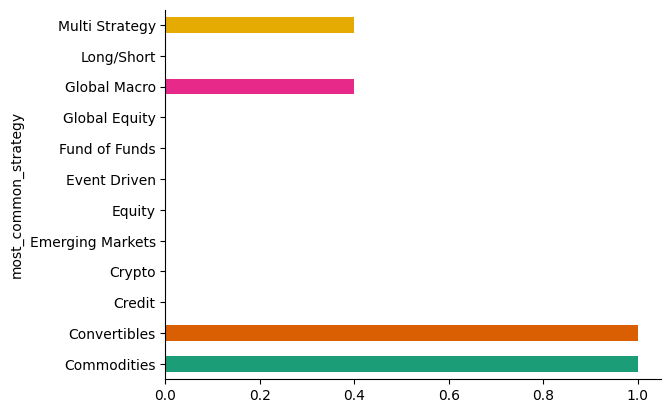

In [24]:
decaying_clusters = cluster_df[cluster_df['avg_log_aum_change'] < cluster_df['avg_log_aum_change'].quantile(0.25)]

prospering_clusters = cluster_df[cluster_df['avg_log_aum_change'] > cluster_df['avg_log_aum_change'].quantile(0.75)]


(decaying_clusters.groupby('most_common_strategy').size() / cluster_df.groupby('most_common_strategy').size()).plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

(prospering_clusters.groupby('most_common_strategy').size() / cluster_df.groupby('most_common_strategy').size()).plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()